In [1]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, SGDRegressor, ElasticNet, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import xgboost as xgb
from pylab import *

import numpy as np
from numpy import linalg as LA
import pandas as pd
import os

# Data

In [2]:
def DPMU(phase,dpmu_data,phase_letter,letter):
    for (columnName, columnData) in phase.iteritems():
        i=0
        if 'Meter' in columnName:
            split = columnName.split('Meter')
            house_name = f'Meter{letter}_'+ split[1]
            i+=1
            dpmu_values = pd.Series(columnData.values).str.replace("i", "j").apply(lambda x: abs(complex(x)))
            dpmu_data[house_name] = dpmu_values
        else:
            split_column_names = columnName.split('_')
            house_name = 'house'+str(split_column_names[phase_letter])
            dpmu_values = pd.Series(columnData.values).str.replace("i", "j").apply(lambda x: abs(complex(x)))
            dpmu_data[house_name] = dpmu_values
    return dpmu_data

In [3]:
def Input(month,input_player_df):
    directory = fr'C:\Users\aniss\grid-edge\data\summer\input_csv\{month}'

    for filename in os.listdir(directory):
        if str(filename).startswith('25.csv'):
            continue
        player = pd.read_csv(os.path.join(directory, filename))
        player['grid'] = player['grid'].str.replace("i", "j").apply(lambda x: complex(x))
        node_id = player['id'].loc[0]
        column_name_p = 'p_'+str(node_id)
        column_name_q = 'q_'+str(node_id)
    #change .head() value to target dataframe row number
        input_player_df[column_name_p] = player['grid'].apply(lambda x: x.real).head(44640)
        input_player_df[column_name_q] = player['grid'].apply(lambda x: x.imag).head(44640)
    return input_player_df

In [4]:
dpmu_phaseA_aug = pd.read_csv(r'C:\Users\aniss\grid-edge\data\summer\targets\trimmed_targets\aug\multi_voltageA.csv')
dpmu_phaseB_aug = pd.read_csv(r'C:\Users\aniss\grid-edge\data\summer\targets\trimmed_targets\aug\multi_voltageB.csv')
dpmu_phaseC_aug = pd.read_csv(r'C:\Users\aniss\grid-edge\data\summer\targets\trimmed_targets\aug\multi_voltageC.csv')

dpmu_phaseA_july = pd.read_csv(r'C:\Users\aniss\grid-edge\data\summer\targets\trimmed_targets\july\multi_voltageA.csv')
dpmu_phaseB_july = pd.read_csv(r'C:\Users\aniss\grid-edge\data\summer\targets\trimmed_targets\july\multi_voltageB.csv')
dpmu_phaseC_july = pd.read_csv(r'C:\Users\aniss\grid-edge\data\summer\targets\trimmed_targets\july\multi_voltageC.csv')

dpmu_phaseA_june = pd.read_csv(r'C:\Users\aniss\grid-edge\data\summer\targets\trimmed_targets\june\multi_voltageA.csv')
dpmu_phaseB_june = pd.read_csv(r'C:\Users\aniss\grid-edge\data\summer\targets\trimmed_targets\june\multi_voltageB.csv')
dpmu_phaseC_june = pd.read_csv(r'C:\Users\aniss\grid-edge\data\summer\targets\trimmed_targets\june\multi_voltageC.csv')

dpmu_phaseA_sept = pd.read_csv(r'C:\Users\aniss\grid-edge\data\summer\targets\trimmed_targets\sept\multi_voltageA.csv')
dpmu_phaseB_sept = pd.read_csv(r'C:\Users\aniss\grid-edge\data\summer\targets\trimmed_targets\sept\multi_voltageB.csv')
dpmu_phaseC_sept = pd.read_csv(r'C:\Users\aniss\grid-edge\data\summer\targets\trimmed_targets\sept\multi_voltageC.csv')

In [5]:
dpmu_phaseA_aug = dpmu_phaseA_aug.drop(['Meter5', '# timestamp'], axis=1)
dpmu_phaseB_aug = dpmu_phaseB_aug.drop(['Meter5', '# timestamp'], axis=1)
dpmu_phaseC_aug = dpmu_phaseC_aug.drop(['Meter5', '# timestamp'], axis=1)

dpmu_phaseA_july = dpmu_phaseA_july.drop(['Meter5', '# timestamp'], axis=1)
dpmu_phaseB_july = dpmu_phaseB_july.drop(['Meter5', '# timestamp'], axis=1)
dpmu_phaseC_july = dpmu_phaseC_july.drop(['Meter5', '# timestamp'], axis=1)

dpmu_phaseA_june = dpmu_phaseA_june.drop(['Meter5', '# timestamp'], axis=1)
dpmu_phaseB_june = dpmu_phaseB_june.drop(['Meter5', '# timestamp'], axis=1)
dpmu_phaseC_june = dpmu_phaseC_june.drop(['Meter5', '# timestamp'], axis=1)

dpmu_phaseA_sept = dpmu_phaseA_sept.drop(['Meter5', '# timestamp'], axis=1)
dpmu_phaseB_sept = dpmu_phaseB_sept.drop(['Meter5', '# timestamp'], axis=1)
dpmu_phaseC_sept = dpmu_phaseC_sept.drop(['Meter5', '# timestamp'], axis=1)

In [6]:
phaseA = 0
phaseB = 1
phaseC = 2
A = "A"
B = "B"
C = "C"

In [7]:
dpmu_data_aug = pd.DataFrame()
dpmu_data_july = pd.DataFrame()
dpmu_data_june = pd.DataFrame()
dpmu_data_sept = pd.DataFrame()

In [8]:
dpmu_data_aug = DPMU(dpmu_phaseA_aug,dpmu_data_aug,phaseA, A)
dpmu_data_aug = DPMU(dpmu_phaseB_aug,dpmu_data_aug, phaseB, B)
dpmu_data_aug = DPMU(dpmu_phaseC_aug,dpmu_data_aug, phaseC, C)

dpmu_data_july = DPMU(dpmu_phaseA_aug,dpmu_data_july,phaseA, A)
dpmu_data_july = DPMU(dpmu_phaseB_aug,dpmu_data_july, phaseB, B)
dpmu_data_july = DPMU(dpmu_phaseC_aug,dpmu_data_july, phaseC, C)

dpmu_data_june = DPMU(dpmu_phaseA_aug,dpmu_data_june,phaseA, A)
dpmu_data_june = DPMU(dpmu_phaseB_aug,dpmu_data_june, phaseB, B)
dpmu_data_june = DPMU(dpmu_phaseC_aug,dpmu_data_june, phaseC, C)

dpmu_data_sept = DPMU(dpmu_phaseA_aug,dpmu_data_sept,phaseA, A)
dpmu_data_sept = DPMU(dpmu_phaseB_aug,dpmu_data_sept, phaseB, B)
dpmu_data_sept = DPMU(dpmu_phaseC_aug,dpmu_data_sept, phaseC, C)

In [9]:
dpmu_data = pd.DataFrame()
dpmu_data = pd.concat([dpmu_data_june, dpmu_data_july,dpmu_data_aug,dpmu_data_sept], ignore_index = True)

In [10]:
dpmu_data_2 = dpmu_data[0:175680]

In [11]:
aug = "aug"
july = "july"
june = "june"
sept = "sept"

In [12]:
input_player_df_aug = pd.DataFrame()
input_player_df_july = pd.DataFrame()
input_player_df_june = pd.DataFrame()
input_player_df_sept = pd.DataFrame()

In [13]:
input_player_df_aug = Input(aug,input_player_df_aug)
input_player_df_july = Input(july,input_player_df_july)
input_player_df_june = Input(june,input_player_df_june)
input_player_df_sept = Input(sept,input_player_df_sept)

In [14]:
input_player_df = pd.DataFrame()
input_player_df = pd.concat([input_player_df_june,input_player_df_july,input_player_df_aug,input_player_df_sept], ignore_index=True)

# Model

In [27]:
def get_scaled_MSE(y_target, y_pred):
    
    y_target = pd.DataFrame(y_target)
    y_pred = pd.DataFrame(y_pred)
    
    #finding L2 norm of the y_target vectors
    L2_ratios = []
    for index, row in y_target.iterrows():
        L2_ratios.append(LA.norm(row))
        
    #dividing all y_pred by the L2 ratios:
    ratio_index = 0
    scaled_ratio_y_pred = []
    for index, row in y_pred.iterrows():
        scaled_ratio_y_pred.append(row/L2_ratios[ratio_index])
        ratio_index += 1
        
    #dividing all y_target by the L2 ratios:
    ratio_index = 0
    scaled_ratio_y_target = []
    for index, row in y_target.iterrows():
        scaled_ratio_y_target.append(row/L2_ratios[ratio_index])
        ratio_index += 1
    
    mse = mean_squared_error(scaled_ratio_y_pred, scaled_ratio_y_target)
    
    return mse

In [28]:
# get the dataset
def get_dataset():
    X, y = input_player_df.copy().to_numpy(), dpmu_data.copy().to_numpy()
    X = X[172000:]
    y = y[172000:]
    X_val = X[:3680]
    y_val = y[:3680]
    return X, y, X_val, y_val

In [29]:
# get the model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(48, activation = 'sigmoid'))
    model.add(Dense(32))
    model.add(Dense(n_outputs))
    a_optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.99, epsilon=1e-07, amsgrad=False,name='Adam')
    model.compile(loss='mse', optimizer=a_optimizer)

    return model

In [30]:
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=1, epochs=200)
        # evaluate model on test set
        mse = model.evaluate(X_test, y_test, verbose=1)
        # store result
        results.append(mse)
    
    return results, model

In [31]:
# load dataset
X, y, X_val, y_val = get_dataset()

# scale target data
y = y/2400
y_val = y_val/2400

In [32]:
# evaluate model
results, model = evaluate_model(X, y)
print('MSE: %.3f (%.3f)' % (mean(results), std(results)))

Epoch 1/200
77/77 [==============================] - 0s 1ms/step - loss: 1.4416
Epoch 2/200
77/77 [==============================] - 0s 929us/step - loss: 1.0135
Epoch 3/200
77/77 [==============================] - 0s 844us/step - loss: 0.7038
Epoch 4/200
77/77 [==============================] - 0s 854us/step - loss: 0.4681
Epoch 5/200
77/77 [==============================] - 0s 879us/step - loss: 0.3072
Epoch 6/200
77/77 [==============================] - 0s 958us/step - loss: 0.2156
Epoch 7/200
77/77 [==============================] - 0s 825us/step - loss: 0.1713
Epoch 8/200
77/77 [==============================] - 0s 895us/step - loss: 0.1490
Epoch 9/200
77/77 [==============================] - 0s 888us/step - loss: 0.1331
Epoch 10/200
77/77 [==============================] - 0s 871us/step - loss: 0.1195
Epoch 11/200
77/77 [==============================] - 0s 828us/step - loss: 0.1071
Epoch 12/200
77/77 [==============================] - 0s 866us/step - loss: 0.0958
Epoch 13/200
77

77/77 [==============================] - 0s 807us/step - loss: 0.0014
Epoch 100/200
77/77 [==============================] - 0s 834us/step - loss: 0.0013
Epoch 101/200
77/77 [==============================] - 0s 794us/step - loss: 0.0013
Epoch 102/200
77/77 [==============================] - 0s 807us/step - loss: 0.0012
Epoch 103/200
77/77 [==============================] - ETA: 0s - loss: 0.001 - 0s 762us/step - loss: 0.0012
Epoch 104/200
77/77 [==============================] - 0s 767us/step - loss: 0.0011
Epoch 105/200
77/77 [==============================] - 0s 804us/step - loss: 0.0011
Epoch 106/200
77/77 [==============================] - 0s 819us/step - loss: 0.0011
Epoch 107/200
77/77 [==============================] - 0s 845us/step - loss: 0.0010
Epoch 108/200
77/77 [==============================] - 0s 809us/step - loss: 9.6405e-04
Epoch 109/200
77/77 [==============================] - 0s 811us/step - loss: 9.1718e-04
Epoch 110/200
77/77 [==============================] - 0s 

77/77 [==============================] - 0s 781us/step - loss: 5.5568e-05
Epoch 193/200
77/77 [==============================] - 0s 783us/step - loss: 5.6337e-05
Epoch 194/200
77/77 [==============================] - 0s 783us/step - loss: 5.5901e-05
Epoch 195/200
77/77 [==============================] - 0s 780us/step - loss: 5.6063e-05
Epoch 196/200
77/77 [==============================] - 0s 790us/step - loss: 5.6135e-05
Epoch 197/200
77/77 [==============================] - 0s 812us/step - loss: 5.5635e-05
Epoch 198/200
77/77 [==============================] - 0s 779us/step - loss: 5.5777e-05
Epoch 199/200
77/77 [==============================] - 0s 787us/step - loss: 5.5642e-05
Epoch 200/200
39/39 [==============================] - 0s 637us/step - loss: 5.6462e-05
Epoch 1/200
77/77 [==============================] - 1s 934us/step - loss: 1.0184
Epoch 2/200
77/77 [==============================] - 0s 844us/step - loss: 0.6893
Epoch 3/200
77/77 [==============================] - 0s 81

77/77 [==============================] - 0s 796us/step - loss: 0.0017
Epoch 90/200
77/77 [==============================] - 0s 851us/step - loss: 0.0016
Epoch 91/200
77/77 [==============================] - 0s 866us/step - loss: 0.0016
Epoch 92/200
77/77 [==============================] - 0s 776us/step - loss: 0.0015
Epoch 93/200
77/77 [==============================] - 0s 791us/step - loss: 0.0015
Epoch 94/200
77/77 [==============================] - 0s 780us/step - loss: 0.0014
Epoch 95/200
77/77 [==============================] - 0s 753us/step - loss: 0.0013
Epoch 96/200
77/77 [==============================] - 0s 771us/step - loss: 0.0013
Epoch 97/200
77/77 [==============================] - 0s 749us/step - loss: 0.0012
Epoch 98/200
77/77 [==============================] - 0s 763us/step - loss: 0.0012
Epoch 99/200
77/77 [==============================] - 0s 787us/step - loss: 0.0011
Epoch 100/200
77/77 [==============================] - 0s 763us/step - loss: 0.0011
Epoch 101/200
77

Epoch 183/200
77/77 [==============================] - 0s 826us/step - loss: 5.3170e-05
Epoch 184/200
77/77 [==============================] - 0s 855us/step - loss: 5.2829e-05
Epoch 185/200
77/77 [==============================] - 0s 868us/step - loss: 5.2946e-05
Epoch 186/200
77/77 [==============================] - 0s 923us/step - loss: 5.3946e-05
Epoch 187/200
77/77 [==============================] - 0s 773us/step - loss: 5.3445e-05
Epoch 188/200
77/77 [==============================] - 0s 795us/step - loss: 5.2500e-05
Epoch 189/200
77/77 [==============================] - 0s 808us/step - loss: 5.2761e-05
Epoch 190/200
77/77 [==============================] - 0s 817us/step - loss: 5.2585e-05
Epoch 191/200
77/77 [==============================] - 0s 820us/step - loss: 5.2335e-05
Epoch 192/200
77/77 [==============================] - 0s 796us/step - loss: 5.3216e-05
Epoch 193/200
77/77 [==============================] - 0s 813us/step - loss: 5.2061e-05
Epoch 194/200
77/77 [===========

77/77 [==============================] - 0s 889us/step - loss: 0.0022
Epoch 80/200
77/77 [==============================] - 0s 839us/step - loss: 0.0021
Epoch 81/200
77/77 [==============================] - 0s 813us/step - loss: 0.0021
Epoch 82/200
77/77 [==============================] - 0s 806us/step - loss: 0.0020
Epoch 83/200
77/77 [==============================] - 0s 810us/step - loss: 0.0020
Epoch 84/200
77/77 [==============================] - 0s 820us/step - loss: 0.0019
Epoch 85/200
77/77 [==============================] - 0s 825us/step - loss: 0.0019
Epoch 86/200
77/77 [==============================] - 0s 827us/step - loss: 0.0018
Epoch 87/200
77/77 [==============================] - 0s 866us/step - loss: 0.0018
Epoch 88/200
77/77 [==============================] - 0s 919us/step - loss: 0.0017
Epoch 89/200
77/77 [==============================] - 0s 778us/step - loss: 0.0017
Epoch 90/200
77/77 [==============================] - 0s 773us/step - loss: 0.0017
Epoch 91/200
77/7

77/77 [==============================] - ETA: 0s - loss: 5.6285e-0 - 0s 752us/step - loss: 5.6254e-05
Epoch 174/200
77/77 [==============================] - 0s 795us/step - loss: 5.6411e-05
Epoch 175/200
77/77 [==============================] - 0s 784us/step - loss: 5.6964e-05
Epoch 176/200
77/77 [==============================] - 0s 781us/step - loss: 5.6221e-05
Epoch 177/200
77/77 [==============================] - 0s 802us/step - loss: 5.6779e-05
Epoch 178/200
77/77 [==============================] - 0s 876us/step - loss: 5.6574e-05
Epoch 179/200
77/77 [==============================] - 0s 833us/step - loss: 5.6229e-05
Epoch 180/200
77/77 [==============================] - 0s 797us/step - loss: 5.5723e-05
Epoch 181/200
77/77 [==============================] - 0s 800us/step - loss: 5.7012e-05
Epoch 182/200
77/77 [==============================] - 0s 864us/step - loss: 5.6072e-05
Epoch 183/200
77/77 [==============================] - 0s 905us/step - loss: 5.6457e-05
Epoch 184/200
77/7

77/77 [==============================] - 0s 814us/step - loss: 0.0027
Epoch 70/200
77/77 [==============================] - 0s 814us/step - loss: 0.0026
Epoch 71/200
77/77 [==============================] - 0s 774us/step - loss: 0.0026
Epoch 72/200
77/77 [==============================] - 0s 709us/step - loss: 0.0025
Epoch 73/200
77/77 [==============================] - 0s 722us/step - loss: 0.0025
Epoch 74/200
77/77 [==============================] - 0s 709us/step - loss: 0.0024
Epoch 75/200
77/77 [==============================] - 0s 748us/step - loss: 0.0023
Epoch 76/200
77/77 [==============================] - 0s 750us/step - loss: 0.0023
Epoch 77/200
77/77 [==============================] - 0s 787us/step - loss: 0.0022
Epoch 78/200
77/77 [==============================] - 0s 796us/step - loss: 0.0021
Epoch 79/200
77/77 [==============================] - 0s 845us/step - loss: 0.0021
Epoch 80/200
77/77 [==============================] - 0s 815us/step - loss: 0.0020
Epoch 81/200
77/7

77/77 [==============================] - 0s 791us/step - loss: 5.5674e-05
Epoch 165/200
77/77 [==============================] - 0s 794us/step - loss: 5.7354e-05
Epoch 166/200
77/77 [==============================] - 0s 761us/step - loss: 5.5334e-05
Epoch 167/200
77/77 [==============================] - 0s 793us/step - loss: 5.5833e-05
Epoch 168/200
77/77 [==============================] - 0s 819us/step - loss: 5.5204e-05
Epoch 169/200
77/77 [==============================] - 0s 814us/step - loss: 5.5469e-05
Epoch 170/200
77/77 [==============================] - 0s 781us/step - loss: 5.6458e-05
Epoch 171/200
77/77 [==============================] - 0s 774us/step - loss: 5.4710e-05
Epoch 172/200
77/77 [==============================] - 0s 810us/step - loss: 5.6028e-05
Epoch 173/200
77/77 [==============================] - 0s 806us/step - loss: 5.4488e-05
Epoch 174/200
77/77 [==============================] - 0s 798us/step - loss: 5.4830e-05
Epoch 175/200
77/77 [=========================

77/77 [==============================] - 0s 829us/step - loss: 0.0036
Epoch 60/200
77/77 [==============================] - 0s 876us/step - loss: 0.0035
Epoch 61/200
77/77 [==============================] - 0s 912us/step - loss: 0.0034
Epoch 62/200
77/77 [==============================] - 0s 877us/step - loss: 0.0033
Epoch 63/200
77/77 [==============================] - 0s 767us/step - loss: 0.0032
Epoch 64/200
77/77 [==============================] - 0s 810us/step - loss: 0.0032
Epoch 65/200
77/77 [==============================] - 0s 779us/step - loss: 0.0031
Epoch 66/200
77/77 [==============================] - 0s 784us/step - loss: 0.0030
Epoch 67/200
77/77 [==============================] - 0s 802us/step - loss: 0.0029
Epoch 68/200
77/77 [==============================] - 0s 818us/step - loss: 0.0029
Epoch 69/200
77/77 [==============================] - 0s 829us/step - loss: 0.0028
Epoch 70/200
77/77 [==============================] - 0s 813us/step - loss: 0.0027
Epoch 71/200
77/7

Epoch 155/200
77/77 [==============================] - 0s 984us/step - loss: 8.2850e-05
Epoch 156/200
77/77 [==============================] - 0s 848us/step - loss: 7.8763e-05
Epoch 157/200
77/77 [==============================] - 0s 755us/step - loss: 7.7401e-05
Epoch 158/200
77/77 [==============================] - 0s 758us/step - loss: 7.4549e-05
Epoch 159/200
77/77 [==============================] - 0s 789us/step - loss: 7.1750e-05
Epoch 160/200
77/77 [==============================] - 0s 768us/step - loss: 7.0694e-05
Epoch 161/200
77/77 [==============================] - 0s 773us/step - loss: 6.7892e-05
Epoch 162/200
77/77 [==============================] - 0s 782us/step - loss: 6.6956e-05
Epoch 163/200
77/77 [==============================] - 0s 760us/step - loss: 6.5639e-05
Epoch 164/200
77/77 [==============================] - 0s 763us/step - loss: 6.4022e-05
Epoch 165/200
77/77 [==============================] - 0s 784us/step - loss: 6.4053e-05
Epoch 166/200
77/77 [===========

77/77 [==============================] - 0s 802us/step - loss: 0.0046
Epoch 51/200
77/77 [==============================] - 0s 805us/step - loss: 0.0044
Epoch 52/200
77/77 [==============================] - 0s 800us/step - loss: 0.0043
Epoch 53/200
77/77 [==============================] - 0s 802us/step - loss: 0.0041
Epoch 54/200
77/77 [==============================] - 0s 788us/step - loss: 0.0040
Epoch 55/200
77/77 [==============================] - 0s 798us/step - loss: 0.0039
Epoch 56/200
77/77 [==============================] - 0s 801us/step - loss: 0.0038
Epoch 57/200
77/77 [==============================] - 0s 829us/step - loss: 0.0037
Epoch 58/200
77/77 [==============================] - 0s 811us/step - loss: 0.0035
Epoch 59/200
77/77 [==============================] - 0s 932us/step - loss: 0.0035
Epoch 60/200
77/77 [==============================] - 0s 805us/step - loss: 0.0034
Epoch 61/200
77/77 [==============================] - 0s 783us/step - loss: 0.0033
Epoch 62/200
77/7

77/77 [==============================] - 0s 761us/step - loss: 7.3977e-05
Epoch 146/200
77/77 [==============================] - 0s 762us/step - loss: 7.2224e-05
Epoch 147/200
77/77 [==============================] - 0s 774us/step - loss: 7.1002e-05
Epoch 148/200
77/77 [==============================] - 0s 774us/step - loss: 6.9807e-05
Epoch 149/200
77/77 [==============================] - 0s 779us/step - loss: 6.9065e-05
Epoch 150/200
77/77 [==============================] - 0s 840us/step - loss: 6.7242e-05
Epoch 151/200
77/77 [==============================] - 0s 806us/step - loss: 6.7516e-05
Epoch 152/200
77/77 [==============================] - 0s 794us/step - loss: 6.5989e-05
Epoch 153/200
77/77 [==============================] - 0s 812us/step - loss: 6.6725e-05
Epoch 154/200
77/77 [==============================] - 0s 1ms/step - loss: 6.4921e-05
Epoch 155/200
77/77 [==============================] - 0s 866us/step - loss: 6.4508e-05
Epoch 156/200
77/77 [===========================

In [33]:
y_pred = model.predict(X_val)

In [34]:
print("MSE: ", get_scaled_MSE(y_val, y_pred))

MSE:  1.5833518530538922e-06


In [ ]:
#unchanged NN
MSE:  1.526009321692549e-06
MSE:  1.5378132031446155e-06
MSE:  1.649536735102701e-06

#added a dense layer 32
MSE:  1.7053129826151832e-06
MSE:  1.557729043377903e-06
MSE:  1.6094094496405183e-06

#n_splits=5 and n_repeats=2
MSE:  1.5711353597012502e-06
MSE:  1.5844211635518706e-06
MSE:  1.5807862672791643e-06

#n_splits=5 and n_repeats=3
MSE:  1.5804823050743733e-06
MSE:  1.5793259986469675e-06

#epsilon= e-07
MSE:  1.4981677795638652e-06
MSE:  1.5628782493334844e-06
MSE:  1.549488753235048e-06

#beta_2=0.999
MSE:  1.5975863793901269e-06
MSE:  1.6180628068501263e-06

In [79]:
y_pred_df = pd.DataFrame(y_pred)

In [80]:
y_val_df = pd.DataFrame(y_val)

# Visualizations

In [59]:
import matplotlib.pyplot as plt

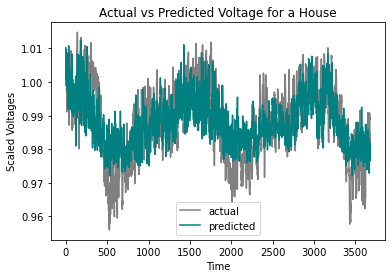

In [120]:
plt.plot(y_val_df[9], label='actual', color='grey')
plt.plot(y_pred_df[9], label='predicted', color='teal')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Scaled Voltages')
plt.title('Actual vs Predicted Voltage for a House')
plt.savefig('/Users/aniss/grid-edge/visuals/nn/house9.jpeg', edgecolor='w', transparent=False)

In [133]:
from tensorflow.keras.utils import plot_model
import os

In [134]:
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [136]:
plot_model(model, to_file='/Users/aniss/grid-edge/visuals/nn/model.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
